# Singular Value Decomposition (SVD)

##### 2.c: evaluate the reconstruction performance on at least two IPSP datasets that were not part of the training

1. Load test data sets and U
3. Transform the test data into the reduced state with $$ X_{test,reduced} = U_{reduced}^T X_{test} $$
4. Reconstruct the reduced test data $ X_{test,reduced} $ with $$ X_{test,reconstr} = U_{reduced} X_{test,reduced}$$
5. Compare the reconstructed test set with the original test set using MSE and variance reconstruction

In [1]:
import torch as pt
from torch import flatten
from os.path import join
import matplotlib.pyplot as plt
import torch.nn.functional as F
plt.rcParams["figure.dpi"] = 180

output_path = "../output/SVD"
data_path = "../data"

test_keys = ['ma0.84_alpha4.50', 'ma0.84_alpha5.00']

#### 1. Load test datasets and U

In [2]:
# Load test datsets
cp_084_data = pt.load(join(data_path, "cp_084_500snaps.pt"))
X_test_1= cp_084_data[test_keys[0]].flatten(0, 1)
X_test_2 = cp_084_data[test_keys[1]].flatten(0, 1)

# Load left singular vectors
U = pt.load(join(output_path, "U.pt"))

#### 2 - 4

In [3]:
# Create a list to loop over an increasing number of left singular vectors
ranks = range(0, 305, 5)

# Initialize lists to save the computed metrics
MSE_1 = []
MSE_2 = []
Var1 = []
Var2 = []

# compute the total variance test datasets
total_Var1 = pt.sum((X_test_1 - pt.mean(X_test_1)) ** 2)
total_Var2 = pt.sum((X_test_2 - pt.mean(X_test_2)) ** 2)

# Loop over the U ranks
for rank in ranks:
    # Compute MSE for test dataset 1
    reduced = pt.transpose(U[:,:rank], 0, 1) @ X_test_1
    reconstructed = U[:,:rank] @ reduced
    MSE_1.append(F.mse_loss(X_test_1, reconstructed).item())

    # Compute variance reconstruction for test dataset 1
    residual_variance = pt.sum((X_test_1 - reconstructed) ** 2)
    explained_variance = total_Var1 - residual_variance
    percentage_reconstruction = (explained_variance / total_Var1) * 100
    Var1.append(percentage_reconstruction)

    # Compute MSE for test dataset 2
    reduced = pt.transpose(U[:,:rank], 0, 1) @ X_test_2
    reconstructed = U[:,:rank] @ reduced
    MSE_2.append(F.mse_loss(X_test_2, reconstructed).item())

    # Compute variance reconstruction for test dataset 2
    residual_variance = pt.sum((X_test_2 - reconstructed) ** 2)
    explained_variance = total_Var2 - residual_variance
    percentage_reconstruction = (explained_variance / total_Var2) * 100
    Var2.append(percentage_reconstruction)
    


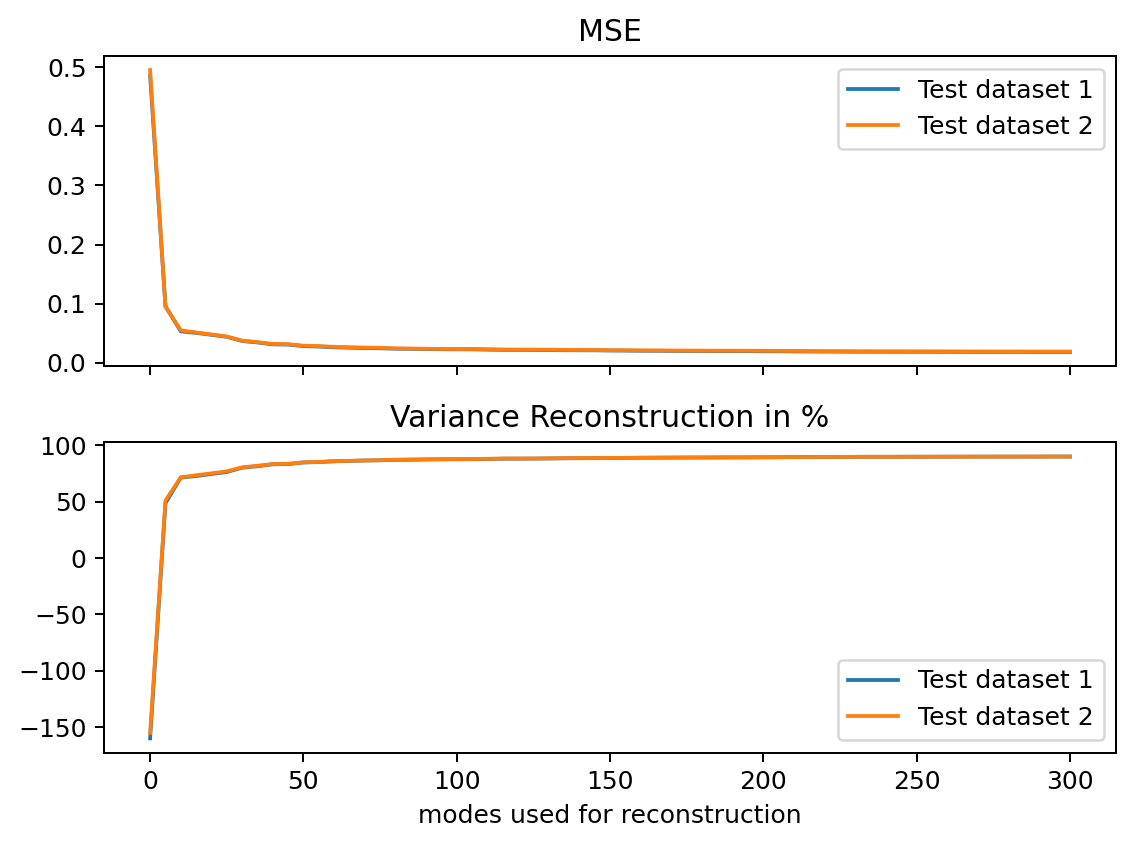

In [4]:
# Plot the results and save the figure
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(ranks, MSE_1, label="Test dataset 1")
ax1.plot(ranks, MSE_2, label="Test dataset 2")
ax1.set_title("MSE")
ax1.legend()
ax2.plot(ranks, Var1, label="Test dataset 1")
ax2.plot(ranks, Var2, label="Test dataset 2")
ax2.set_title("Variance Reconstruction in %")
ax2.set_xlabel("modes used for reconstruction")
ax2.legend()
fig.tight_layout()
fig.savefig(join(output_path, "MSE_and_Variance_with_rank.png"))